In [1]:
import pandas as pd
import numpy as np

from numpy.linalg import norm
from sklearn.decomposition import PCA

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

Extract network features and use them to compute similarity between 20 seeds in the <b>finance domain</b> and <b>random users</b>.

The idea is to keep part of the seeds as seeds and the other part as good candidates, while all the random users are bad candidates. In this way it is possible to assess automatically the goodness of the method, because the groundtruth is already validated.

Steps to follow:
1. Split seeds in candidates and effective seeds (10/10)
2. Compute centroid with effective seeds
3. Rank random users and candidates with respect to the centroid
4. Compute #good candidates extracted at each level of ranking and plot the resulting line against the random ranking (linear)
5. Iterate with different splits
6. Compare with respect to the fingerprint method

In [2]:
# ranking is based on distance similarity
def candidatesRanking(candidates, centroid, features):
    #centroid_v = np.array(centroid[features])
    
    output = pd.DataFrame()
    output['distance'] = candidates.apply(lambda x: norm(np.array(x[features]) - centroid), axis=1)
    output['username'] = candidates['username']
    output['id_user'] = candidates['id_user']
    output['similarity'] = output.apply(lambda x: 1/(1+x['distance']), axis=1)
    #output['link'] = output.apply(lambda x: 'www.twitter.com/'+x['username']+'/', axis=1)
    
    output.sort_values(by='similarity', ascending=False, inplace=True)
    
    return output

In [3]:
def computeCentroid(seeds, normheader):
    arrays = [np.array(x[normheader]) for index, x in seeds.iterrows()]
    
    return np.sum(arrays, axis=0)/seeds.shape[0]

In [4]:
def cumulativeGoodCandidates(ranking):
    cumulative = []
    n_good_candidates = 0
    
    for index, ranked_user in ranking.iterrows():
        if ranked_user['good'] == True:
            n_good_candidates = n_good_candidates + 1
        cumulative.append(n_good_candidates)
        
    return np.array(cumulative)

In [18]:
def plotData(seeds, candidates, components):
    x = components[0]
    y = components[1]
    
    plt.figure(figsize=(12,12))
    plt.scatter(candidates[x], candidates[y], marker='.', s=40, lw=0, alpha=0.7)
    plt.scatter(seeds[x], seeds[y], marker='x', color='red')

In [28]:
def computeSimDistribution(ranking, float_prec):
    prec_str = '%.{}f'.format(float_prec)
    ranking['truncated'] = ranking.apply(lambda x: float(prec_str%(x['similarity'])), axis=1)
    
    y = ranking.groupby(by='truncated').count().reset_index()[['truncated','similarity']]
    y.columns = ['sim','freq']
    y.sort_values(by='sim', inplace=True)
    
    return y

In [6]:
header = ['{}'.format(i) for i in range(1,9)]

In [7]:
domain = 'finance_20'
path = '{}/random-test/'.format(domain)
datapath = 'data-seed/{}/'.format(domain)
randompath = 'data-random/'

In [8]:
allseeds = map(str, list(pd.read_csv(datapath+'/user.csv', sep='\t')['id_user']))
len(allseeds)

20

## Complete Hashtags Network

In [9]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'h_network_nodes.csv', sep='\t') # match graph id and user instance
data = pd.read_csv(path+'user_features_h.emb', sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)
data.columns = ['id_graph','username','id_user','usertype']+header

data = data[data['usertype'].isin(['seed','user'])]
data.reset_index(inplace=True)
data.head()

,index,id_graph,username,id_user,usertype,1,2,3,4,5,6,7,8
0,0,1,laurenlacapra,36361027,seed,2.516750,-1.38746,-1.73805,-0.335531,-4.44016,3.83019,-1.49479,-0.382628
1,179,180,lamonicabuzz,104952689,seed,0.711539,-2.28252,-1.78525,1.230670,-3.10466,3.18194,-0.08606,-1.112030
2,320,321,bill_easterly,35810531,seed,1.012040,-2.54304,-2.56074,2.442140,-6.25920,5.67939,-1.79177,2.783370
3,420,421,fgoria,6361512,seed,1.312650,-2.71393,-1.08411,1.604560,-4.00625,1.90800,1.14075,0.640406
4,594,595,firoozye,31137628,seed,0.437857,-2.22417,-2.23374,2.082960,-6.87650,6.64438,-1.11809,-1.736550


In [10]:
data.shape[0]

1536

In [56]:
# PCA features
n = 4
pca = PCA(n_components = n)
pcaheader = ['pca{}'.format(i) for i in range(n)]

X = pd.DataFrame(pca.fit_transform(data[header]))
X.columns = pcaheader

data = pd.concat([data, X], axis=1)

print 'Explained variance with {} components: {:.2f}'.format(n, sum(pca.explained_variance_ratio_))

Explained variance with 4 components: 0.68


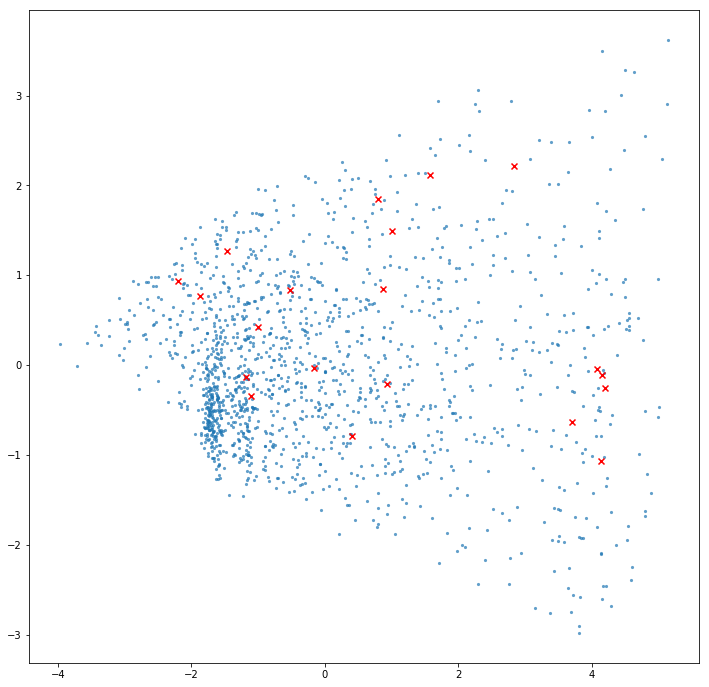

In [19]:
plotData(data[data['id_user'].isin(allseeds)], data[~data['id_user'].isin(allseeds)], pcaheader)

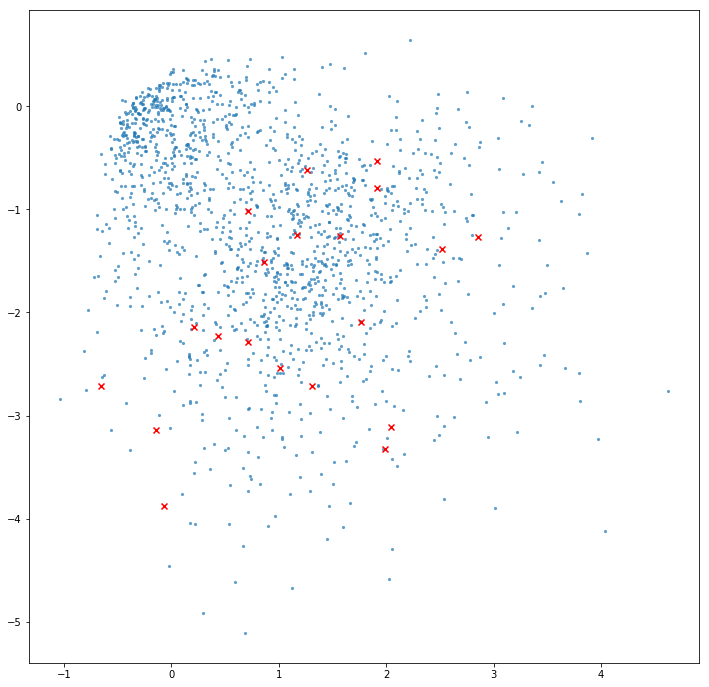

In [20]:
plotData(data[data['id_user'].isin(allseeds)], data[~data['id_user'].isin(allseeds)], header)

In [61]:
N = 10

ysum = np.zeros(data.shape[0] - N)
alldistr = pd.DataFrame(columns=['sim','freq'])
combinations = 100
for seeds in list(itertools.combinations(allseeds, N))[:combinations]:
    effective_seeds = list(seeds)
    good_candidates = list(set(allseeds)-(set(effective_seeds)))
    
    seedsVectors = data[data['id_user'].isin(effective_seeds)]
    centroid = computeCentroid(seedsVectors, header)
    candidates = data[~data['id_user'].isin(effective_seeds)]

    r = candidatesRanking(candidates, centroid, header)
    r['good'] = r.apply(lambda x: True if x['id_user'] in good_candidates else False, axis=1)
    y = cumulativeGoodCandidates(r)
    ysum = ysum + y
    
    sim_distr = computeSimDistribution(r, 3)
    alldistr = pd.concat([alldistr, sim_distr])
    
y_avg = ysum.astype(float)/combinations

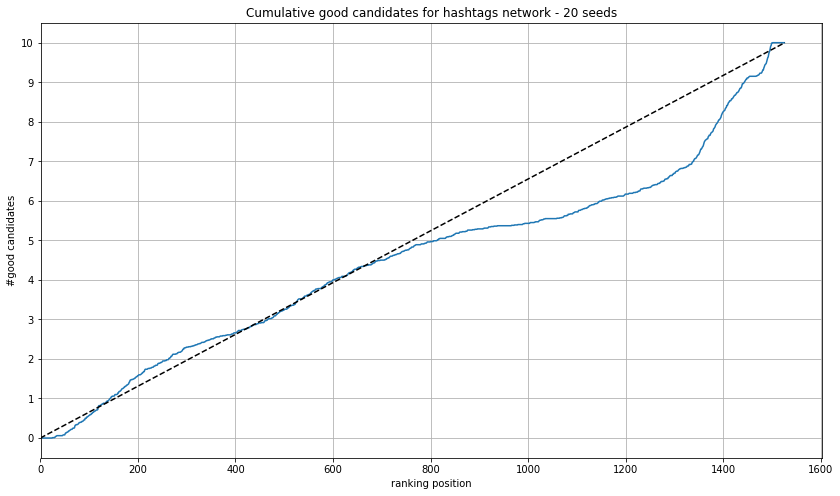

In [62]:
plt.figure(figsize=(14,8))
plt.title('Cumulative good candidates for hashtags network - 20 seeds')
plt.ylabel('#good candidates')
plt.xlabel('ranking position')

plt.plot(y_avg)
plt.plot([0, len(y_avg)],[0, 10], linestyle='--', color='black')
plt.xlim(xmin=1)

plt.yticks(range(11))
plt.grid(True)

In [63]:
temp = pd.DataFrame(alldistr, dtype = float)
s = temp.groupby(by='sim').mean().reset_index()
s.sort_values(by='sim', inplace=True)

Mean: 6.2452656493 Standard Deviation: 5.93305151383


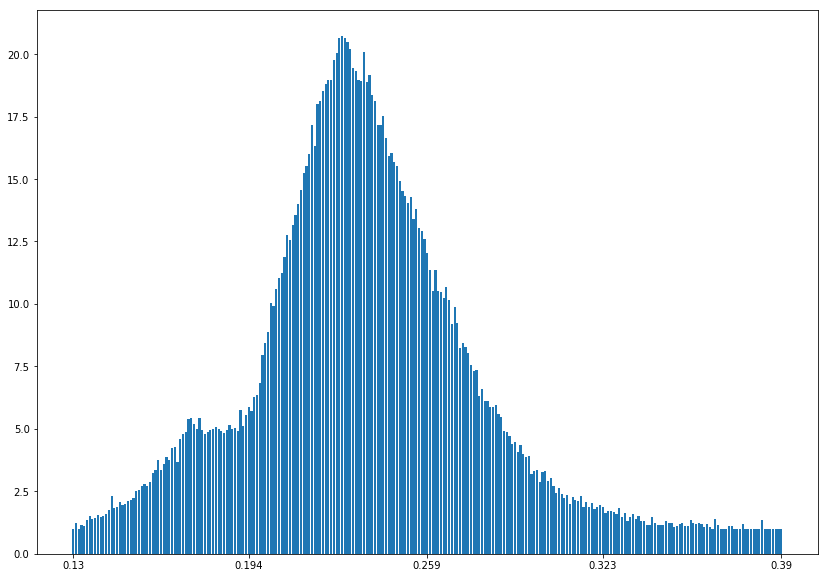

In [64]:
# plot of the average similarity distribution among different rankings
dim = s.shape[0] - 1
labeled_pos = [0, dim/4, dim/2, 3*dim/4, dim]
label_ticks = list(s.iloc[labeled_pos]['sim'])

x = range(s.shape[0])
bar_width = 0.8

plt.figure(figsize=(14,10))
#plt.title(title)
plt.bar(x, s['freq'],bar_width)
plt.xticks(labeled_pos, label_ticks)

mu = np.mean(s['freq'])
sigma = np.std(s['freq'])

print 'Mean: {}'.format(mu), 'Standard Deviation: {}'.format(sigma)

## Nouns Network [To Do]

In [9]:
# features file reading and metadata inclusion
userdata = pd.read_csv(path+'h_network_nodes.csv', sep='\t') # match graph id and user instance
data = pd.read_csv(path+'user_features_h.emb', sep=' ', header=None, skiprows=1)
data = userdata.merge(data, left_on='id', right_on=0)
data.drop(0, inplace=True, axis=1)
data.columns = ['id_graph','username','id_user','usertype']+header

data = data[data['usertype'].isin(['seed','user'])]
data.reset_index(inplace=True)
data.head()

,index,id_graph,username,id_user,usertype,1,2,3,4,5,6,7,8
0,0,1,laurenlacapra,36361027,seed,2.516750,-1.38746,-1.73805,-0.335531,-4.44016,3.83019,-1.49479,-0.382628
1,179,180,lamonicabuzz,104952689,seed,0.711539,-2.28252,-1.78525,1.230670,-3.10466,3.18194,-0.08606,-1.112030
2,320,321,bill_easterly,35810531,seed,1.012040,-2.54304,-2.56074,2.442140,-6.25920,5.67939,-1.79177,2.783370
3,420,421,fgoria,6361512,seed,1.312650,-2.71393,-1.08411,1.604560,-4.00625,1.90800,1.14075,0.640406
4,594,595,firoozye,31137628,seed,0.437857,-2.22417,-2.23374,2.082960,-6.87650,6.64438,-1.11809,-1.736550


In [10]:
data.shape[0]

1536

In [26]:
# PCA features
n = 2
pca = PCA(n_components = n)

X = pd.DataFrame(pca.fit_transform(data[header]))
X.columns = pcaheader

data = pd.concat([data, X], axis=1)

print 'Explained variance with {} components: {:.2f}'.format(n, sum(pca.explained_variance_ratio_))

Explained variance with 2 components: 0.50


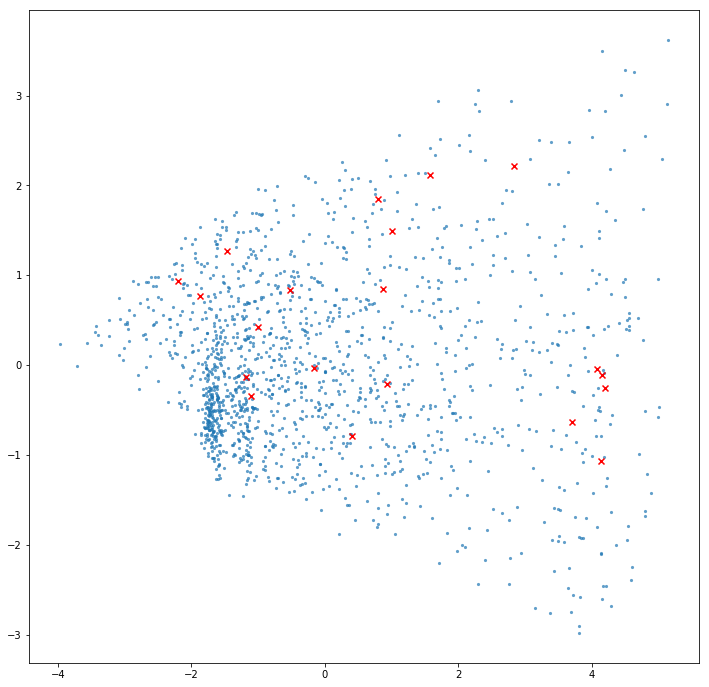

In [19]:
plotData(data[data['id_user'].isin(allseeds)], data[~data['id_user'].isin(allseeds)], pcaheader)

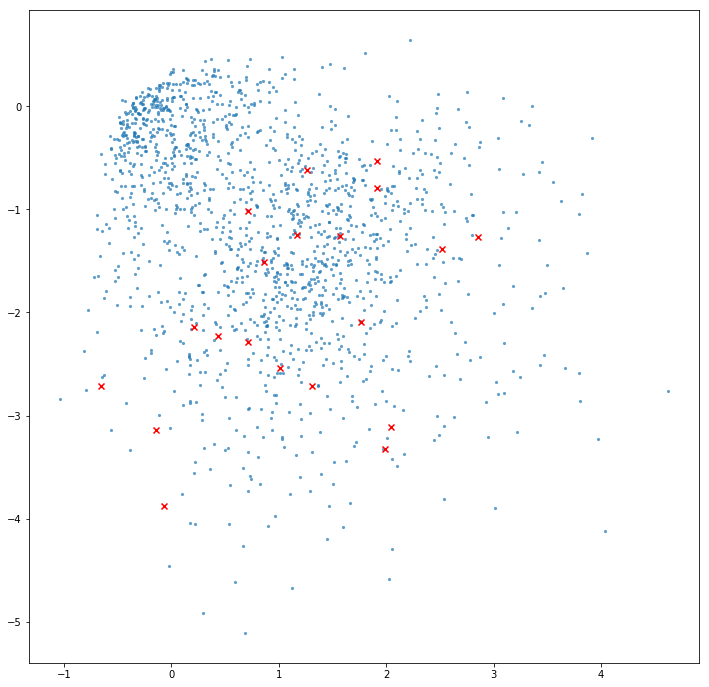

In [20]:
plotData(data[data['id_user'].isin(allseeds)], data[~data['id_user'].isin(allseeds)], header)

In [21]:
# in the reduced case, only 15 seeds are kept so N must be lower than 10
N = 10

ysum = np.zeros(data.shape[0] - N)
combinations = 100
for seeds in list(itertools.combinations(allseeds, N))[:combinations]:
    effective_seeds = list(seeds)
    good_candidates = list(set(allseeds)-(set(effective_seeds)))
    
    seedsVectors = data[data['id_user'].isin(effective_seeds)]
    centroid = computeCentroid(seedsVectors, header)
    candidates = data[~data['id_user'].isin(effective_seeds)]

    r = candidatesRanking(candidates, centroid, header)


    r['good'] = r.apply(lambda x: True if x['id_user'] in good_candidates else False, axis=1)
    y = cumulativeGoodCandidates(r)
    ysum = ysum + y
    
y_avg = ysum.astype(float)/combinations

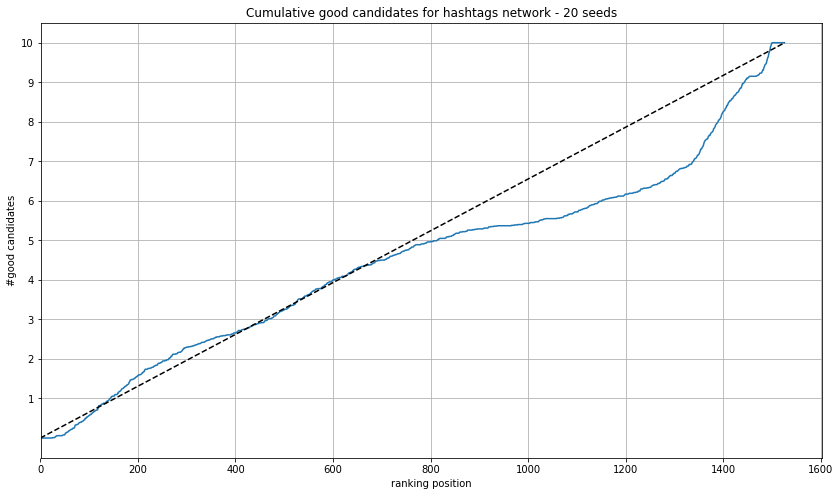

In [22]:
plt.figure(figsize=(14,8))
plt.title('Cumulative good candidates for hashtags network - 20 seeds')
plt.ylabel('#good candidates')
plt.xlabel('ranking position')

plt.plot(y_avg)
plt.plot([0, len(y_avg)],[0, 10], linestyle='--', color='black')
plt.xlim(xmin=1)

plt.yticks(range(1,11))
plt.grid(True)